In [1]:
import os,sys
import csv
import copy
import math
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
from IPython.display import HTML
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d
from scipy import signal
sys.path.append("/pymorph")

import logging
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.CRITICAL)

import morph_geom_lib as mgl


import models.parameterized_morph_models as parameter_models
import models.parameterized_models.parameterized_exner_models as exner_models
#import models.simple_depth_morph_models as simple_models
# import models.shallow_depth_morph_models_org as sdmodels

import schemes.avalanche_scheme 
import utils.post_processing as post

from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex
from matplotlib import animation, rc

import schemes.weno as weno
import sediment_transport.sed_trans as sedtrans
from schemes.avalanche_scheme import avalanche_model, get_slope
from models.shallow_water_solver import shallow_water_solver

rc('animation', html='html5')
%matplotlib widget
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use(['default'])

# Section 5.3

In this section we revisit the simple morphyodynamic model which eliminates the shallow water solved and focuses on just the convection of the the dunes.

dx: 0.6505421184320267 cm
nx 1200


Text(0, 0.5, 'z (m)')

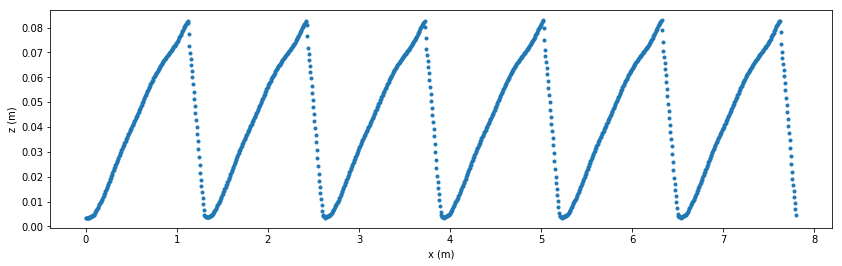

In [2]:
filepath = 'dune_profile_dune5_repeated.txt'

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    


def readFile(filepath, resolution_cells = 800):
    xs = []
    zs = []
    with open(filepath) as f:
        for line in f:
            values = line.split(',')
            if is_number(values[0]) and is_number(values[1]):
                x = float(values[0])
                z = float(values[1])
                xs.append(x)
                zs.append(z)
                
    xs = np.array(xs)
    zs = np.array(zs)
    
    #--------------------------------
    # Increase the resolution on the grid
    #--------------------------------
    xmax = xs.max()
    nx = len(xs)
    f = interp1d(xs, zs)
    
    xnew = np.linspace(0., xmax, num=resolution_cells)
    znew = f(xnew)
    return xnew, znew

x0,z0 = readFile(filepath, resolution_cells = 1200)

dx = x0[1] - x0[0]

print('dx: {0} cm'.format(dx*100.))
print('nx {0}'.format(len(x0)))

fig = plt.figure(figsize=(14, 4))
plt.plot(x0,z0, '.')
plt.xlabel('x (m)')
plt.ylabel('z (m)')

In [3]:
#--------------------------------
# Set up the bed properties
#--------------------------------
D50 = 0.001
repose_angle = 30.
rho_particle = 2650.
nP = 0.4

#--------------------------------
# Set up the Boundary conditions
#--------------------------------
# 32 cm Case 
Qc132 = 0.0455
Qc120 = 0.020
B = 0.76
Qtotal32 = Qc132 * 3.
Qtotal20 = Qc120 * 3.
q32cm = Qtotal32 / B
q20cm = Qtotal20 / B

# Water Surface Elevation
sOut32 = 0.357
sOut20 = 0.237

#--------------------------------
# Set up the Flow Proerties
#--------------------------------
mannings_n = 0.024
bed_slope = 1.26/1000.
ks=0.002

#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 300*60       # Runtime in seconds
dt = 0.25                # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 60.*5

## 32 cm Case

This is the basic case. The z was transformed to a qsb to achieve the desired migration rate. The migration rate was extracted from the graph of profiles (guess I could have done it more accurately from the actual data)? The measured migration rate was 0.95 m/hr. The model uses the following:  qbedload = [((zs - 0.0134)/0.079 * 0.0000127) for zs in z]

$
q_{sb} = \frac{z}{\Delta}q_{sb}^{max}
$

This equation basically says that the bed load is equal to the local local elevation multiplied by the peak bedload. the $q_{sb}^{max}$ is calibrated to match the migration rate of the dune.

 Starting simulation....
Number of time steps: 1200.0 mins
Grid dx = 0.0065054211843202665
Grid nx = 1200
Initializing hydrodynamic model...
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Time step: 5.0 mins - uavg: 0.0 - Elevation 0.042865264831644635
Courant number: max 0.01029650816834391, mean0.010293430115529884
Time step: 10.0 mins - uavg: 0.0 - Elevation 0.042865264831644635
Courant number: max 0.010296508168343849, mean0.01029613414803961
Time step: 15.0 mins - uavg: 0.0 - Elevation 0.04286526483164464
Courant number: max 0.010296508168343882, mean0.010294428290956415
Time step: 20.0 mins - uavg: 0.0 - Elevation 0.04286526483164464
Courant number: max 0.010296508168352266, mean0.010295840111069895
Time step: 25.0 mins - uavg: 0.0 - Elevation 0.042865264831644635
Courant number: max 0.010296508168353584, mean0.010295436634162351
Time step: 30.0 mins - uavg: 0.0 - Elevation 0.04286526483164464
Courant number: max 0.010

Text(0, 0.5, 'z (m)')

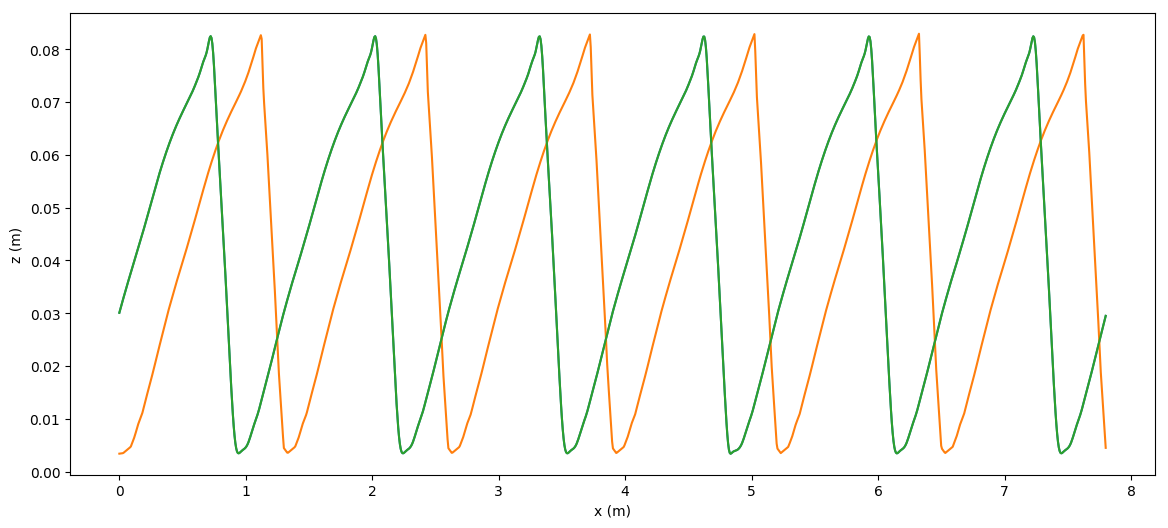

In [17]:
model = parameter_models.ParameterizedMorphologicalModel()

run_name = 'Section_5.3.dune_5_q_{0}_h_{1}_D50_{2}_{3}'.format('32m','357mm','1.0mm','2ndTVD')

#--------------------------------
# Set up the geometry
#--------------------------------
xc = x0.copy()
zc = z0.copy()
nx = len(xc)

model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q32cm, sOut32)
model.setup_chezy_hydro_model(ks, bed_slope)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
#morph_model = exner_models.TVD3rdWenoModel()
morph_model = exner_models.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)

#---------------------------------
# Specific properties for the case
#----------------------------------
qsbmax = 0.0000127
delta = 0.079
zoffset = 0.0034
qsbmodel = parameter_models.EquilibriumBedloadModel(qsbmax, delta, zoffset)
model.set_bedload_model(qsbmodel)

xc, zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h



df = model.get_wave_dataframe()
df.to_csv('_output/{0}_waves.csv'.format(run_name))
np.save('_output/{0}_z.npy'.format(run_name),zc)
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

Text(0, 0.5, 'z (m)')

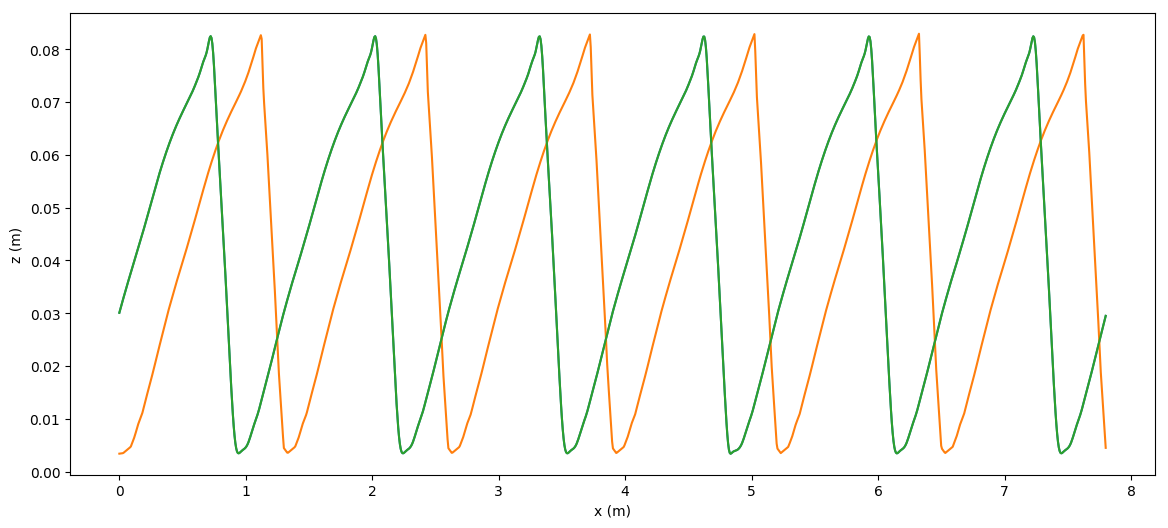

In [18]:
fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

In [4]:
run_name = 'Section_5.3.dune_5_q_{0}_h_{1}_D50_{2}'.format('32m','357mm','1.0mm')

df = model.get_wave_dataframe()
df.to_csv('_output/{0}_waves.csv'.format(run_name))
np.save('_output/{0}_z.npy'.format(run_name),zc)
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
#plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

NameError: name 'model' is not defined

ValueError: If mode is 'interp', window_length must be less than or equal to the size of x.

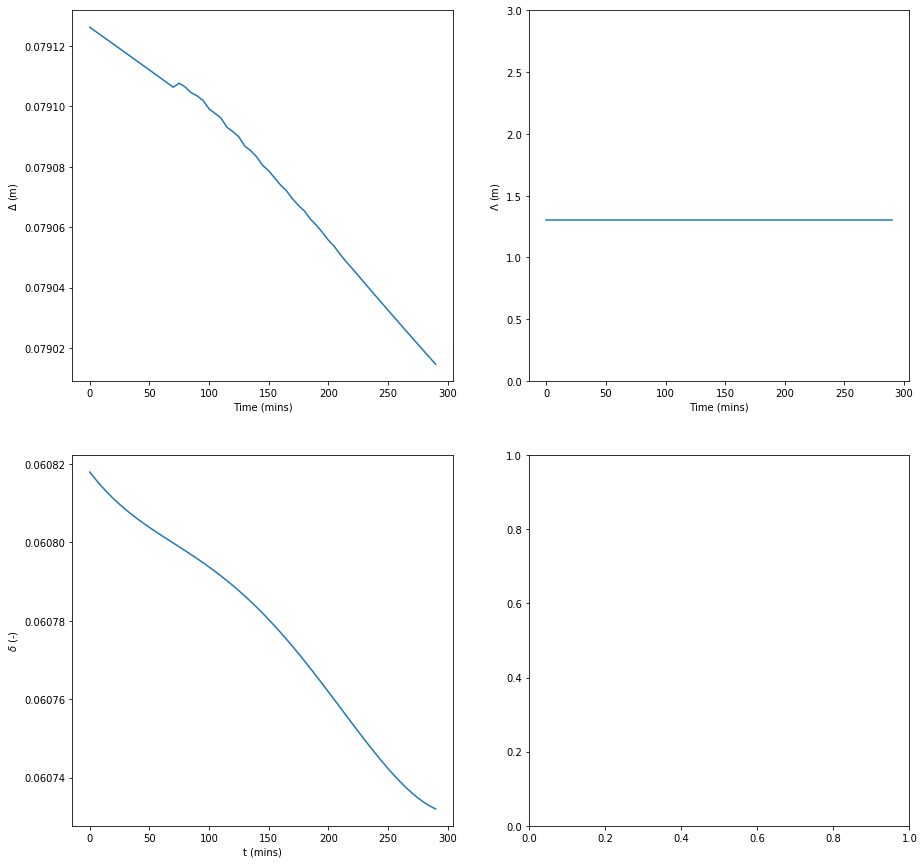

In [5]:
verts = np.load('_output/{0}_verts.npy'.format(run_name))

dx = x0[1] - x0[0]
post.plot_results(verts, dx, dt, extractionTime)

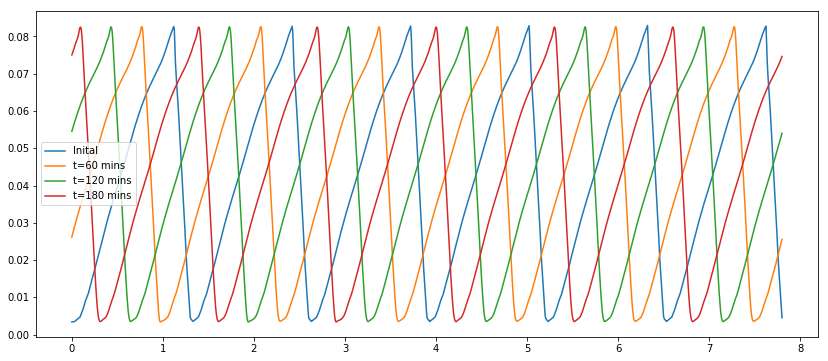

In [17]:
fig = plt.figure(figsize=(14, 6))

plt.plot(x0,z0, label='Inital')
plt.plot(verts[11,:,0], verts[11,:,1], label='t=60 mins')

plt.plot(verts[23,:,0], verts[23,:,1], label='t=120 mins')

plt.plot(verts[35,:,0], verts[35,:,1], label='t=180 mins')

#plt.plot(verts[47,:,0], verts[47,:,1], label='t=240 mins')
plt.legend()

#plt.plot(verts[58,:,0], verts[29,:,1], label='t=300 mins')

In [21]:
#--------------------------------
#  Initialize the model
#--------------------------------

model = parameter_models.ParameterizedMorphologicalModel()
model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q20cm, sOut20)
model.setup_chezy_hydro_model(ks, bed_slope)


#-------------------------
# Set the bedload formula
#-------------------------

a = 0.0000127
b = 2
c = 1.
d = -0.02


qsbmax = 0.0000127
delta = 0.079
zoffset = 0.0034
c = 1.0
d = -0.02 #0.2
qsbmodel = parameter_models.NonEquilibriumBedloadModel(qsbmax, delta, zoffset, c, d)
model.set_bedload_model(qsbmodel)

morph_model = exner_models.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False)


xc, zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)


Initalized
 Starting simulation....
Number of time steps: 1200.0 mins
Grid dx = 0.0065054211843202665
Grid nx = 1200
Initializing hydrodynamic model...
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Time step: 5.0 mins - uavg: 0.0 - Elevation 0.04286526483117621
Courant number: max 0.01891306308679492, mean0.010281283797941883
Time step: 10.0 mins - uavg: 0.0 - Elevation 0.04286526483057967
Courant number: max 0.01742166355494316, mean0.010349365095298962
Time step: 15.0 mins - uavg: 0.0 - Elevation 0.04286526482995908
Courant number: max 0.01636919122843276, mean0.010438279056836315
Time step: 20.0 mins - uavg: 0.0 - Elevation 0.04286526482989688
Courant number: max 0.01557859067531503, mean0.01052368632749666
Time step: 25.0 mins - uavg: 0.0 - Elevation 0.04286526482964914
Courant number: max 0.014945507187329461, mean0.010596389614875175
Time step: 30.0 mins - uavg: 0.0 - Elevation 0.04286526482923692
Courant number: max 

In [18]:
run_name = 'Section_5.3.dune_5_q_{0}_h_{1}_D50_{2}'.format('20m','237mm','1.0mm')

df = model.get_wave_dataframe()
df.to_csv('_output/{0}_waves.csv'.format(run_name))
np.save('_output/{0}_z.npy'.format(run_name),zc)
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
#plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

NameError: name 'model' is not defined

ValueError: If mode is 'interp', window_length must be less than or equal to the size of x.

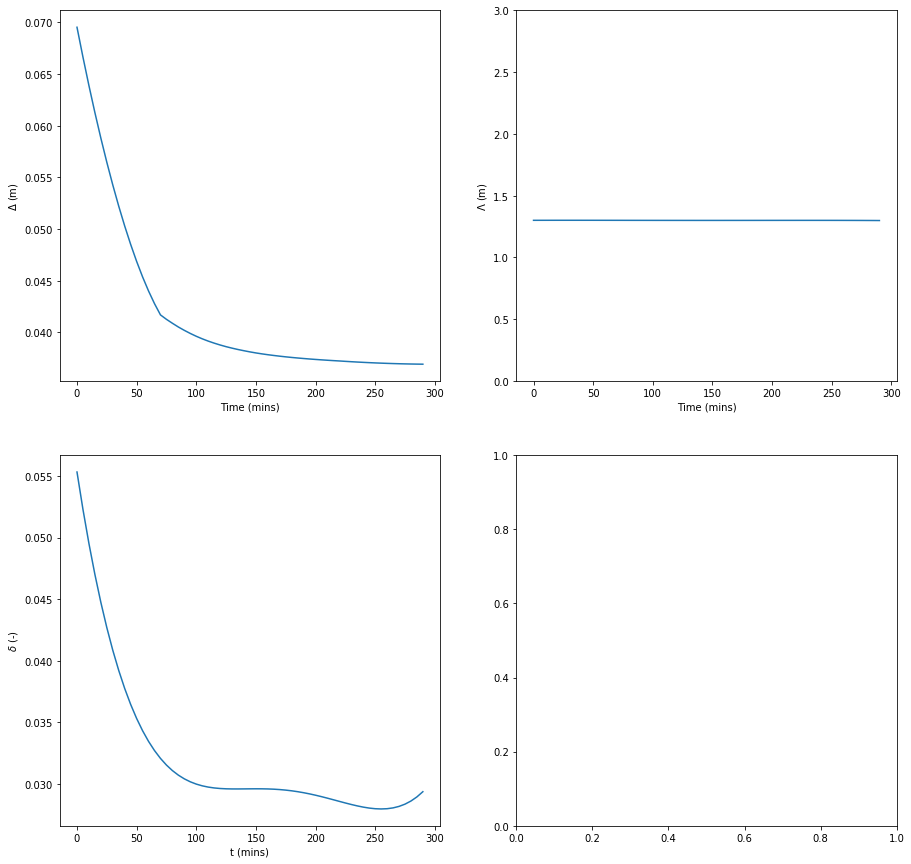

In [19]:
verts = np.load('_output/{0}_verts.npy'.format(run_name))

dx = x0[1] - x0[0]
post.plot_results(verts, dx, dt, extractionTime)

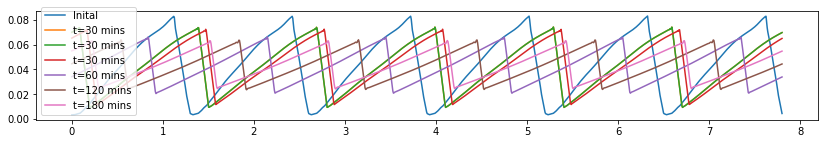

In [26]:
fig = plt.figure(figsize=(14, 2))

plt.plot(x0,z0, label='Inital')

plt.plot(verts[1,:,0], verts[2,:,1], label='t=30 mins')
plt.plot(verts[2,:,0], verts[2,:,1], label='t=30 mins')

plt.plot(verts[3,:,0], verts[3,:,1], label='t=30 mins')

plt.plot(verts[11,:,0], verts[11,:,1], label='t=60 mins')

plt.plot(verts[23,:,0], verts[23,:,1], label='t=120 mins')

plt.plot(verts[35,:,0], verts[35,:,1], label='t=180 mins')

#plt.plot(verts[47,:,0], verts[47,:,1], label='t=240 mins')
plt.legend()

#plt.plot(verts[58,:,0], verts[29,:,1], label='t=300 mins')